# Error Mitigation using Pauli Propagation

Since hardware related errors on quantum computers can not be fully error-corrected yet, many classical techniques have been developed which can account for errors.
This is known as **Quantum Error Mitigation**, and it's a classical post-processing step for calculations on NISQ-quantum computers. 

For the correction of expectation values of observables, the leading error mitigation techniques are zero-noise extrapolation (ZNE) and probabilistic error cancellation (PEC). To get an overview of common methods, the mitiq documentation is very useful (https://mitiq.readthedocs.io/en/stable/guide/guide.html, see the "What is the theory behind ...?" subriders). 

However, these techniques come with a cost: they imply an overhead in terms of quantum ressources. In the case of the IBM utility experiment, ZNE required to run over half a million of quantum circuits! In this notebook, we reach similar error mitigation using Pauli Propagation (PP). It means no overhead in quantum resources, it only requires a few minutes of computation on a laptop (it can be much longer depending on the truncation coefficients chosen). This notebook should run entirely in roughly 45s, as long as you do not change the truncation coefficients currently set ; ).

Here's an overview of what we'll cover in this notebook:

- We'll start with the most intuitive and widely used error mitigation method, Zero Noise Extrapolation (ZNE).

- Then we'll focus on an error mitigation technique called Clifford Data Regression (CDR), and an extension to  this method, Clifford Perturbation Approximation (CPA).

- Next, we can combine these 2 approaches in order to achieve even better correction. The combined technique is called variable noise CDR (CDR + ZNE = vnCDR).  We are in fact combining CPA and ZNE to Clifford Perturbation Data Regression - ZNE (CPDR - ZNE), but the main principle stays the same. 

- Finally, we apply these methods on IBM's utility experiment (https://doi.org/10.1038/s41586-023-06096-3).

If you are interested in the background of these methods, these are the original papers
:
CDR was introduced in 2021 (http://arxiv.org/abs/2005.10189), as well as vnCDR (https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.033098). The origin of Clifford Perturbation Theory, which CPA is based on, was introduced in 2023 (http://arxiv.org/abs/2306.04797). The improved vnCDR method (CPDR-ZNE) we use was introduced in 2024 (http://arxiv.org/abs/2412.09518).


DISCLAIMER: if you plan to perform error mitigation using PP and use some of our code, we advise you to have a look to our "advanced" notebook as well. We show there more methods that we have tried out and have many more functions defined. The present notebook intends to give only an overview of how error mitigation can be performed with PP.

In [1]:
# necessary imports
using PauliPropagation
using Plots
using GLM
using DataFrames
using Logging
using Distributions
using LaTeXStrings
using MLJLinearModels
using MLJBase
using LsqFit

# Target circuit

The system we are interested in simulating is the transverse-field Ising model (TFIM) on a heavy-hex lattice, where the Hamiltonian is given by
$$
 H = -J\sum_{<i,j>}Z_iZ_j+h\sum_i X_i .
 $$
The first-order Trotterization of the time-dependent Schödinger equation is
$$
\begin{align}
 \ket{\psi(T)} &= \prod_{k=1}^N e^{-i\frac{T}{N}H} \ket{\psi(0)} \\
    &\approx \prod_{k=1}^N \left(\prod_{<i,j>} e^{i \frac{JT}{N}Z_i Z_j } \prod_i e^{-i \frac{hT}{N}X_i} \right) \ket{\psi(0)} \\
    &= \prod_{k=1}^N \left[ \prod_{<i,j>} R_{Z_i Z_j} \left(\theta_J\right) \prod_i R_{X_i}\left(\theta_h\right) \right] \ket{\psi(0)},
 \end{align}
 $$
with $T$ the final time, $N$ the number of time steps, $\displaystyle\theta_J= -\frac{2TJ}{N}$ and $\displaystyle\theta_h = \frac{2Th}{N}$.
<!--  WHAT TOPOLOGY? -->


We start by defining our target circuit within PP and visualizing the time evolution we want to correct. This 
is done just for visualizatlion purposes in this notebook. We use here moderate truncations, with `min_abs_coeff=1e-6` and `max_weight=15`. The simulations can be done exactly only for small and shallow circuits if we do not use any truncations. In practise the 'ground truth' comparison may well not be available for interesting problem sizes.

In [2]:
## CIRCUIT PARAMETERS
## number of qubits
nq = 31 

## number of steps (layers)
steps = 20 

## time step
dt = 0.05

## final time
T = steps*dt

## physical parameters of the model
J =  2.0 # J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0  # in ordered phase: abs(h) < abs(J)

## truncations coefficients
min_abs_coeff=1e-6
max_weight=15

## TOPOLOGY
## 3 loops of heavy hex: works only with 31 qubits
topology = [(1, 2), (1, 15), (2, 3), (3, 4), (4, 5), (5, 6), (5, 16), (6, 7), (7, 8), (8, 9), (9, 10), (9, 17),
            (10, 11), (11, 12), (12, 13), (13, 14), (13, 18), (15, 19), (16, 23), (17, 27), (18, 31), (19, 20),
            (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28),
            (28, 29), (29, 30), (30, 31)];

# topology=bricklayertopology(nq)  

## OBSERVABLE
## ⟨ZZ⟩
observable = PauliSum(nq);    
for i in 1:length(topology)
    q1 = topology[i][1]
    q2 = topology[i][2]
    add!(observable, [:Z, :Z], [q1, q2]);
end
observable = observable/length(topology);

## magnetization ⟨Z⟩
# observable = PauliSum(nq)
# for i in 1:nq
#     add!(observable,:Z, i)
# end
# observable = observable/nq;

## <Z_15>
# observable = PauliSum(nq)
# add!(observable, :Z, 15);

PauliSum(nqubits: 31, 33 Pauli terms:
 0.030303 * IIIIIIIIIIIIIIIIIIII...
 0.030303 * IZZIIIIIIIIIIIIIIIII...
 0.030303 * IIIIIIIIIIIIIIIIIIII...
 0.030303 * IIIIIIIIZZIIIIIIIIII...
 0.030303 * IIIIIIIIIIIIIIIIIIII...
 0.030303 * IIIIIIIIIIIIZZIIIIII...
 0.030303 * IIIIIIIIIIIIIIIIIIII...
 0.030303 * IIIIIIIIIIIZZIIIIIII...
 0.030303 * IIIIZZIIIIIIIIIIIIII...
 0.030303 * IIIIIZZIIIIIIIIIIIII...
 0.030303 * IIIIIIIZZIIIIIIIIIII...
 0.030303 * IIIIIIIIZIIIIIIIZIII...
 0.030303 * IIIIIIIIIIIIIIZIIIZI...
 0.030303 * IIIIIIIIIIIIIIIIIZII...
 0.030303 * IIIIIIIIIIIIIIIZIIII...
 0.030303 * IIIIIIIIIIIIIIIIIIII...
 0.030303 * IIIIIIIIIIIIIIIIIIII...
 0.030303 * IIIIIIIIIZZIIIIIIIII...
 0.030303 * IIIIIIIIIIIIIIIIIIIZ...
 0.030303 * IIIIIIIIIIIIIIIIIIII...
  ⋮)

We will create a circuit made out of parametrized gates. To perform the simulation, we have to feed the parameters of the gates to the `propagate` function. In the present case, our parametrized gates are Pauli rotations and the parameters are the angles $\theta_h$ and $\theta_J$ defined in the equation 3. We define the function `define_thetas` that will set up our vector of angles.

In [3]:
function define_thetas(circuit::Vector{Gate}, dt::Float64, J::Float64=2.0, h::Float64=1.0)
    # get indices indicating which angle corresponds to which gate 
    rzz_indices = getparameterindices(circuit, PauliRotation, [:Z, :Z])
    rx_indices = getparameterindices(circuit, PauliRotation, [:X])
    
    nparams = countparameters(circuit)
    thetas = zeros(nparams)
    
    # following eq. (3)
    thetas[rzz_indices] .= - J * dt * 2
    thetas[rx_indices] .= h * dt * 2

    return thetas
end

define_thetas (generic function with 3 methods)

Let's compute the approximate noiseless expectation value for our circuit.

In [4]:
# define 1 layer of the trotterized TFIM circuit
layer = tfitrottercircuit(nq, 1, topology=topology)
thetas = define_thetas(layer, dt, J, h)
 
# need a deep copy of our observable, because this is the variable that we evolve!
obs = deepcopy(observable)
exact_expval_target = Float64[]   
push!(exact_expval_target, overlapwithzero(obs))
# apply the layer of the circuit for each time step
for i in 1:steps
    # we choose slightly lower truncations so we are closer to ground truth
    psum = propagate!(layer, obs, thetas; min_abs_coeff=5e-7, max_weight=20)
    # save the expectation value after each time step
    push!(exact_expval_target, overlapwithzero(psum))
end

Now, we compute the corresponding noisy evolution. We add depolarizing and dephasing noise after each layer. The strength was tuned by hand to roughly approximate the noise level of experimental data from IBM utility experiment, to make sure we are correcting realistic noise.

In [5]:
depol_strength, dephase_strength = 0.02, 0.02;

In [6]:
noisy_expval_target = Float64[]   
# don't forget the deep copy of the observable!
obs = deepcopy(observable)
push!(noisy_expval_target, overlapwithzero(obs))
for i in 1:steps
    psum = propagate!(layer, obs, thetas; min_abs_coeff=min_abs_coeff, max_weight=max_weight)
    # applying depolarizing and dephasing noise
    for (pstr, coeff) in psum
        # for each term (Pauli string) in the Pauli sum,
        # we adjust its coefficient according to the noise effects
        set!(psum, pstr, coeff*(1-depol_strength)^countweight(pstr)*(1-dephase_strength)^countxy(pstr))
    end
    # save the expectation value after each time step
    push!(noisy_expval_target, overlapwithzero(psum))
end


For convenience, we define the function `trotter_time_evolution` that performs the time evolution for the given system. We give it a few extra arguments not used yet that will be useful later.

In [7]:
function trotter_time_evolution(
    steps::Int64,
    layer::Vector{Gate},
    observable::PauliSum{UInt64, Float64},
    thetas::Vector{Float64};
    noise=false,
    min_abs_coeff=1e-10,
    max_weight = Inf,
    depol_strength=0.02, 
    dephase_strength=0.02,
    noise_level = 1.0
    )

    """
    Function that computes the time evolution of the ansatz using the first order Trotter approximation exact time evolution operator.
    The function returns the overlap of the final state with the |0> state.
    """
    obs = deepcopy(observable)
    expvals_trotter = Float64[]   
    push!(expvals_trotter, overlapwithzero(obs))
    for i in 1:steps
        psum = propagate!(layer, obs, thetas; min_abs_coeff=min_abs_coeff, max_weight=max_weight)
        if noise
            for (pstr, coeff) in psum
                set!(psum, pstr, 
                    coeff*(1-noise_level*depol_strength)^countweight(pstr)*(1-noise_level*dephase_strength)^countxy(pstr))
            end 
        end
        push!(expvals_trotter, overlapwithzero(psum))
    end
    return expvals_trotter  
end

## example of a function call to compute the noisy expectation values:
# noisy_expval_target = trotter_time_evolution(
#   steps, layer, observable, thetas;
#   noise=true,
#   min_abs_coeff=min_abs_coeff, max_weight=max_weight,
#   depol_strength=depol_strength, dephase_strength=dephase_strength);


trotter_time_evolution (generic function with 1 method)

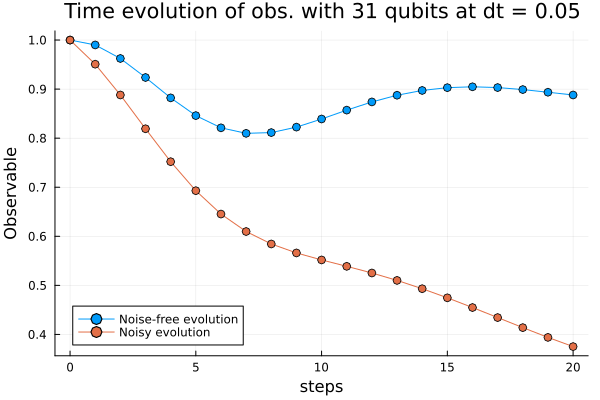

In [8]:
plot(0:steps, exact_expval_target, xlabel="steps", label="Noise-free evolution", marker=:o)
plot!(0:steps, noisy_expval_target, label="Noisy evolution", marker=:o)

plot!(ylabel="Observable", title ="Time evolution of obs. with $(nq) qubits at dt = $(round((T/steps), digits = 2))")


As we can see from the plot above, the noise affects the expectation value. Instead of following the exact evolution in blue, the noise model causes the expectation value to evolve according to the orange line.

How can we recover the exact expectation value, given only the noisy data? 

# ZNE
The most intuitive error mitigation strategy is zero noise extrapolation, where one artifically scales the noise in a quantum circuit to a set of noise levels, and then extrapolates to the zero noise value.

On a quantum computer, this can be done by inserting identity gates (mapping a gate $G$ to $\mathbb{I} G$) or with unitary folding (mapping a gate $G$ to $GG^\dagger G$). Instead of using a quantum computer for noisy data, we simulate the noisy circuits within Pauli Propagation by building a generic noise model. Here, we can directly set the noise levels to the desired values.
 
Performing ZNE using PP presents two main advantages:
- you don't need to adjust/add noise on your quantum hardware, so it avoids potentially cumbersome circuit modifications 
- noisy simulations are actually easier than the noiseless ones with PP: depolarizing noise shrinks the accessible Bloch sphere, thus reducing the coefficient of terms different from the maximally mixed state. If the coefficients are small enough (and that is the case for high enough noise level), they can be truncated.

First, we calculate the noisy expectation values for a set of `noise_levels`.

In [9]:
noise_levels = [1.0,1.3,1.5,1.8,2.0,2.2]

# performing the trotter time evolution for each noise level
noisy_expval_target_levels = Array{Float64,2}(undef, length(noise_levels), steps+1)
for (idx, level) in enumerate(noise_levels)
    expval_target = trotter_time_evolution(
        steps, layer, observable, thetas;
        noise=true, noise_level=level,
        min_abs_coeff=min_abs_coeff, max_weight=max_weight,
        depol_strength=depol_strength, dephase_strength=dephase_strength)
    noisy_expval_target_levels[idx, :] .= expval_target
end

From the plot above, it is not immediately clear with which fit we will get the best correction.
Let's plot only the last step of the time evolution in semi-log scale.

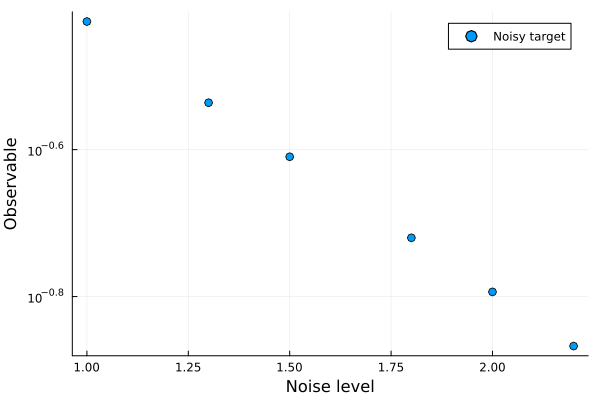

In [10]:
noisy_exp_last = noisy_expval_target_levels[:,end];
scatter(noise_levels, noisy_exp_last,
     xlabel="Noise level",
     ylabel="Observable",
     label="Noisy target",
     marker=:o,
     legend=:topright, yaxis=:log)

We see that an exponential fit is a good choice (the points are nearly on a line on log scale).
Let's check the correction quickly only for the last time step:

In [11]:
# exponential model
exp_model(x, p) = p[1] .+ p[2] .* exp.(-p[3] .* x)
# initial guess of the coefficient
p0 = [noisy_exp_last[end], noisy_exp_last[1] - noisy_exp_last[end], 1.0]
fit_ = curve_fit(exp_model, noise_levels, noisy_exp_last, p0)
# extrapolate to 0-noise using the fitted model
corrected_ZNE_last = exp_model(0.0, fit_.param)

# absolute errors before and after correction 
abs_error_before_ZNE_last = abs(exact_expval_target[end] - noisy_exp_last[1]) 
abs_error_after_ZNE_last = abs(exact_expval_target[end] - corrected_ZNE_last) 

println("Noisy value: ", round(noisy_exp_last[1], digits = 2))
println("Corrected value: ", round(corrected_ZNE_last, digits = 2))
println("Absolute error before correction: ", round(abs_error_before_ZNE_last, digits = 2))
println("Absolute error after correction: ",round(abs_error_after_ZNE_last, digits = 5))

Noisy value: 0.38
Corrected value: 0.88
Absolute error before correction: 0.51
Absolute error after correction: 0.01237


Let's wrap up this fitting procedure for one time step in a function to simplify the next steps.

In [12]:
function zne(noisy_exp::Vector{Float64}, noise_levels::Vector{Float64}, exact_exp::Float64)
    # exponential model
    model(x, p) = p[1] .+ p[2] .* exp.(-p[3] .* x)
    # initial guess of the coefficient
    p0 = [noisy_exp[end], noisy_exp[1] - noisy_exp[end], 1.0]
    fit_ = curve_fit(model, noise_levels, noisy_exp, p0)
    # extrapolate to 0-noise using the fitted model
    corrected = model(0.0, fit_.param)

    # absolute errors before and after correction 
    abs_error_after = abs(exact_exp - corrected) 
    abs_error_before = abs(exact_exp - noisy_exp[1]) # assumes that the first noise_level is the smallest
    return corrected, abs_error_after, abs_error_before
end

## example of a function call to compute the corrected value at the last time step:
# corr_ZNE_last,
# abs_error_after_ZNE_last,
# abs_error_before_ZNE_last = zne(noisy_exp_last, noise_levels, exact_expval_target[end])

zne (generic function with 1 method)

Now, we perform ZNE for each time step and visualize how good the correction over time is.

In [13]:
corrected_ZNE = Array{Float64, 1}(undef, steps+1)
abs_error_after_ZNE = Array{Float64, 1}(undef, steps+1)
abs_error_before_ZNE = Array{Float64, 1}(undef, steps+1)
for i in 1:steps+1
    corrected_ZNE[i],
    abs_error_after_ZNE[i],
    abs_error_before_ZNE[i] = zne(noisy_expval_target_levels[:,i], noise_levels, exact_expval_target[i])
end

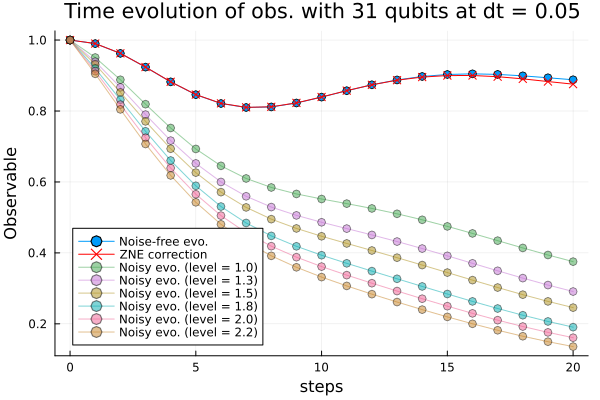

In [14]:
plot(0:steps, exact_expval_target, xlabel="steps", label="Noise-free evo.", marker=:o, legend=:bottomleft)
plot!(0:steps, corrected_ZNE, label="ZNE correction", marker=:x, color ="red")

for i in 1:length(noise_levels)
    plot!(0:steps, noisy_expval_target_levels[i,:], label="Noisy evo. (level = $(noise_levels[i]))", marker=:o, alpha = 0.5)
end
plot!(ylabel="Observable", title ="Time evolution of obs. with $(nq) qubits at dt = $(round((T/steps), digits = 2))")

ZNE works well for this noise model. However, one must ensure that the noise is not too dominant. If so, the system thermalizes and the noisy values all converge to the same value regardless of the noise strength. In this case, one can not extrapolate anymore. 

# Clifford Data Regression (CDR) 
Instead of using variable-noise data (ZNE), the CDR approach performs error mitigation using variable near-Clifford circuit data.

CDR consists of the following steps:
1) Choose circuits $\ket{\phi_i}$ that are efficiently simulable and "close" to the target circuit (i.e. we replace some or all gates). This gives a set of close circuits $S_\psi  = \{\ket{\phi_i}\}$.
2) Generate a training set 
$ \mathcal{T}_\psi  = \{ X_{\phi_i}^{\text{noisy}} , X_{\phi_i}^{\text{exact}} \} $ 
by calculating the exact and noisy expectation values of all circuits in $S_\psi$.
3) Choose an ansatz to define the relation between the noisy and exact data: $ X_\psi^{\text{exact}} = f( X_\psi^{\text{noisy}},\underline{a})$. Learn the parameters $\underline{a}$ and then predict the noiseless expectation value of the target.

### 1) Training data
There are multiple ways to generate the training set for CDR. Since we are interested in the small angle regime (we want a good time resolution of the trotterized evolution), the Clifford Perturbation Approximation approach (CPA) is suitable. 

Instead of only allowing for Clifford gate replacements (standard CDR), the replaced gates can be within a small interval around Clifford gates (`angle_definition`).
This allows us to closer approximate the target circuit, while leveraging the fact that PP is efficient for small angles.

In the CPA paper, they create a deterministic training set with 144 circuits, where:
$$ \mathcal{T} = \{(\theta_h, \theta_J) \vert \theta_h = i\pi/120, \theta_h = j\pi/120; \,\,\,i,j=0,1,2,3,4,5,54,55,56,57,58,59\}.$$
This means that the training set is the same independent of the $J$ and $h$ parameters.

To enhance expressiveness of the training circuits, we opted for a slightly different approach, that we call "loose" approach. Instead of drawing random values within the angle definition range around Cliffords, we keep the angles that are already smaller than the angle definition. This approach has a drawback: if both $\theta_h$ and $\theta_J$ are smaller than the angle definition, we do not create a training set but are solving directly the evolution of the target circuit. This case will be discussed when we will correct IBM's utility experiment.

In the present case, we have $\theta_h=0.1$ and $\theta_J=-0.2$. The angle definition is $\pi/20\approx0.16$, meaning that we can keep $\theta_h$ fixed but choose a random $\theta_J$ in the interval $[-\pi/20, 0]$.


Remark on the original CDR approach:
In the original CDR approach, a fixed number of gates are replaced by Clifford gates. In order to guarantee similar expectation values of the training set, one needs to assume further information on the system (such as prior information of the groundstate when observing the energy). Since we do not want to use any prior information for the time evolution, we have to opt for a more expressive approach. We do so by keeping intact the dynamics of the system, i.e. just changing the parameters of our Hamiltonian.

In [15]:
angle_definition = pi/20

# number of training circuits
num_samples = 7

list_training_thetas = Vector{Vector{Float64}}()
training_thetas = deepcopy(thetas)

# get where the theta_J are in the vector of angles
theta_J_indices = getparameterindices(layer, PauliRotation, [:Z, :Z])

for _ in 1:num_samples
    new_tht_J = rand(Uniform(-angle_definition, 0.0))
    training_thetas[theta_J_indices] .= new_tht_J
    push!(list_training_thetas, deepcopy(training_thetas))
end

### 2) Training set generation

We evolve all the training circuits (with and without noise) using the previously defined `trotter_time_evolution` function.

In [16]:
exact_expvals_training = Array{Float64,2}(undef, length(list_training_thetas), steps+1)
# evolve each training circuit without noise
for (i, thetas) in enumerate(list_training_thetas)
    exact_expvals_training[i, :] = trotter_time_evolution(
        steps, layer, observable, thetas;
        noise=false,
        min_abs_coeff=min_abs_coeff, max_weight=max_weight,
        depol_strength=depol_strength, dephase_strength=dephase_strength)
end

In [17]:
noisy_expvals_training = Array{Float64,2}(undef, length(list_training_thetas), steps+1)
# evolve each training circuit with noise
for (i, thetas) in enumerate(list_training_thetas)
    noisy_expvals_training[i, :] = trotter_time_evolution(
        steps, layer, observable, thetas;
        noise=true,
        min_abs_coeff=min_abs_coeff, max_weight=max_weight,
        depol_strength=depol_strength, dephase_strength=dephase_strength)
end

We now visualize the evolutions of some of the training circuits. The solid lines represent the noisy and noiseless evolutions of the target circuit . The transparent lines represent the evolution of the training circuits, with a plus marker for noiseless values and a cross marker for the noisy ones.

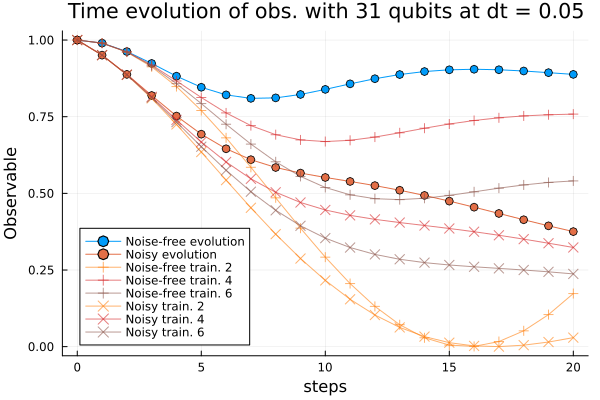

In [18]:
colors = palette(:tab10)
plot(0:steps, exact_expval_target; xlabel="steps", label="Noise-free evolution", marker=:o, legend=:bottomleft)
plot!(0:steps, noisy_expval_target; label="Noisy evolution", marker=:o)

for i in 2:2:size(exact_expvals_training)[1]
    plot!(0:steps, exact_expvals_training[i, :]; label="Noise-free train. $i", c=colors[i], marker=:+, markersize = 5, alpha=0.6)
end

for i in 2:2:size(noisy_expvals_training)[1]
    plot!(0:steps, noisy_expvals_training[i, :]; label="Noisy train. $i", color=colors[i], marker=:x, markersize = 5, alpha=0.6)
end

plot!(ylabel="Observable", title ="Time evolution of obs. with $(nq) qubits at dt = $(round((T/steps), digits = 2))")

We observe that the training circuits look like they behave very differently from the target circuit. Well, yes. But importantly, the trotterized evolution is not modified during the evolution itself, i.e. we keep the two same angles during the whole evolution. This means our training circuits are physically relevant circuits in the sense that they all represent a physical evolution. We can not get closer to the target evolution while still respecting the physics of our problem, as we are varying only $\theta_J$.

### 3) CDR
Just as in the original CDR paper, we start by correcting the noisy expecation value with a linear ansatz. The motivation is that this ansatz is the exact solution for a general quantum erasure noise channel, which takes the input state $\rho$ to
$$
  \rho \rightarrow (1-p_\text{error}) \rho  + p_\text{error}\ \rho_0 .
$$
Thus, we can perform least squares regression (which assumes Gaussian noise) to find the optimal parameters $a_1,a_2$ in the following dependency for the noiseless expectation value
$$
X_\psi^{\text{exact}} = f( X_\psi^{\text{noisy}},a )  = a_1 X_\psi^{\text{noisy}} + a_2 .
$$

Note that we cannot correct noise during time evolution, since we only working with the expectation values and cannot reconstruct the corrected state from one expectation value.


We first correct only the last step of the time evolution.

In [19]:
noisy_expvals_training_last = noisy_expvals_training[:, end]
exact_expvals_training_last = exact_expvals_training[:, end]
noisy_expval_target_last = noisy_expval_target[end]
exact_expval_target_last = exact_expval_target[end]

lin_model(x, p) = p[1] .+ p[2] .* x
# initial guess of the coefficient
p0 = [exact_expvals_training_last[1], (exact_expvals_training_last[end]-exact_expvals_training_last[1])/(noisy_expvals_training_last[end] - noisy_expvals_training_last[1]), 1.0]
fit_ = curve_fit(lin_model, noisy_expvals_training_last, exact_expvals_training_last, p0)
# extrapolate to 0-noise using the fitted model
corrected_CDR_last = lin_model(noisy_expval_target_last, fit_.param)

abs_error_after_CDR_last = abs(exact_expval_target_last - corrected_CDR_last) 
abs_error_before_CDR_last = abs(exact_expval_target_last - noisy_expval_target_last) 

println("Noisy value at the last timestep: ", round(noisy_expval_target_last, digits = 2))
println("Corrected value at the last timestep: ", round(corrected_CDR_last, digits = 2))
println("Absolute error before correction: ", round(abs_error_before_CDR_last,digits =2))
println("Absolute error after correction: ", round(abs_error_after_CDR_last, digits = 4))

Noisy value at the last timestep: 0.38
Corrected value at the last timestep: 0.83
Absolute error before correction: 0.51
Absolute error after correction: 0.0543


Let's see what the fit looks like.

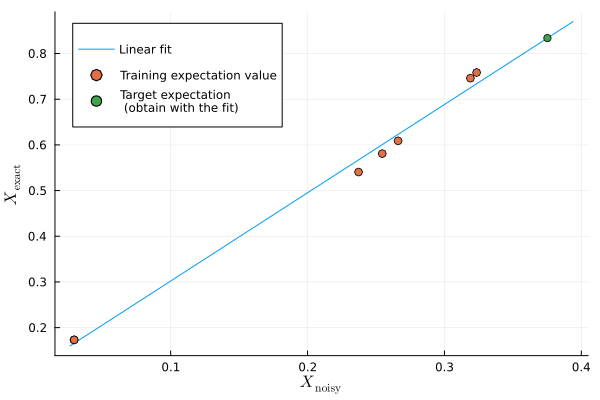

In [20]:
x = LinRange(min(minimum(noisy_expvals_training_last)*0.9, noisy_expval_target_last), max(maximum(noisy_expvals_training_last), noisy_expval_target_last)*1.05, 100)
plot(x, lin_model.(x, fill(fit_.param, length(x))), label="Linear fit")
scatter!(noisy_expvals_training_last, exact_expvals_training_last, marker=:o, label="Training expectation value")
scatter!([noisy_expval_target_last], [corrected_CDR_last], label="Target expectation\n (obtain with the fit)")
plot!(xlabel=L"$X_{\textrm{noisy}}$", ylabel=L"$X_{\textrm{exact}}$")

Again, we wrap this up in a nice function.

In [21]:
function cdr(noisy_exp_values::Array{Float64, 1},
            exact_exp_values::Array{Float64, 1},
            noisy_target_exp_value::Float64,
            exact_target_exp_value::Float64)
    """
    Function that computes the CDR correction for a single noisy expectation value.
    """

    lin_model(x, p) = p[1] .+ p[2] .* x
    # initial guess of the coefficient
    p0 = [exact_exp_values[1], (exact_exp_values[end]-exact_exp_values[1])/(noisy_exp_last[end] - noisy_exp_last[1]), 1.0]
    fit_ = curve_fit(lin_model, noisy_exp_values, exact_exp_values, p0)
    # extrapolate to 0-noise using the fitted model
    corrected = lin_model(noisy_target_exp_value, fit_.param)

    abs_error_after = abs(exact_target_exp_value - corrected) 
    abs_error_before = abs(exact_target_exp_value - noisy_target_exp_value) 
    return corrected, abs_error_after, abs_error_before
end

## example of a function call to compute the corrected value at the last time step:
# corr_CDR_last, abs_error_after_CDR_last, abs_error_before_CDR_last = cdr(
#     noisy_expvals_training_last,
#     exact_expvals_training_last,
#     noisy_expval_target_last,
#     exact_expval_target_last
# )

cdr (generic function with 1 method)

We now do CDR for all time steps to visualize the evolution of the correction. As before for ZNE, we are only considering the current time step for our correction. It is important to note that we can not correct the state itself, we can correct expectation values only.

In [22]:
corrected_CDR = Array{Float64, 1}(undef, steps+1)
abs_error_after_CDR = Array{Float64, 1}(undef, steps+1)
abs_error_before_CDR = Array{Float64, 1}(undef, steps+1)
for i in 1:steps+1
    corrected_CDR[i], 
    abs_error_after_CDR[i],
    abs_error_before_CDR[i] = cdr(
        noisy_expvals_training[:, i],
        exact_expvals_training[:, i],
        noisy_expval_target[i],
        exact_expval_target[i])
end

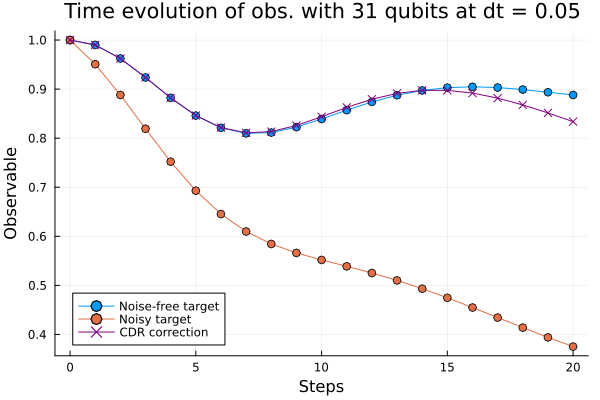

In [23]:
#plot time evolution
plot(0:steps, exact_expval_target; xlabel="Steps", label="Noise-free target", marker=:o, legend=:bottomleft)
plot!(0:steps, noisy_expval_target; label="Noisy target", marker=:o)
plot!(0:steps, corrected_CDR; label="CDR correction", marker=:x, color = "purple")

plot!(ylabel="Observable", title ="Time evolution of obs. with $(nq) qubits at dt = $(round((T/steps), digits = 2))")

CDR is quite performant until step 8 before visibly deviating from the exact evolution. This can be explained by the fact that noise does not follow the exact evolution trend anymore: it keeps decreasing even though the noiseless expectation value increases again from step 7. Thus, it becomes impossible to find a meaningful relationship between noiseless and noisy expectation values.

This hypothesis can be easily verified by changing the noise strength! For `depol_strength` and `dephas_strength` equal to 0.1, CDR performs well until step 14.

# vnCDR
The CDR and ZNE method can be combined to improve the error correction.
For each circuit from the training set, one calculates the expectation value at multiple noise levels, as well as the corresponding noiseless expectation value. Note here that vnCDR works with the varied noise levels of the *training* circuits, while ZNE works with the varied noise levels of the *target* circuit.

This subtlety is crucial: vnCDR gets the better out of PP, as its uses near-Clifford circuits (small angles around Cliffords only) and noisy simulations, where ZNE can require to run circuits very hard to simulate classically.

More precisely, we will be implementing CPDR-ZNE as described in the CPA paper. This is based on the same idea as vnCDR, but allows for a small angle perturbation from Cliffords in the training circuit generation.

We first compute the noiseless expectation values for our training circuits.

In [24]:
exact_expvals_training_levels = Array{Float64,2}(undef, length(list_training_thetas), steps+1)
# iterate over training circuits (i.e. different thetas)
for (i, thetas) in enumerate(list_training_thetas)
    exact_expvals_training_levels[i, :] = trotter_time_evolution(
        steps, layer, observable, thetas;
        noise=false,
        min_abs_coeff=min_abs_coeff, max_weight=max_weight,
        depol_strength=depol_strength, dephase_strength=dephase_strength)
end

We now compute the noisy expectation values with different noise levels for each training circuit.

In [25]:
noisy_expvals_training_levels = Array{Float64,3}(undef, length(noise_levels), length(list_training_thetas), steps+1) # 3D array: (noise_levels, circuits, steps+1)
# iterate over noise levels
for (idx, level) in enumerate(noise_levels)
    # iterate over training circuits (i.e. different thetas)
    for (i, thetas) in enumerate(list_training_thetas)
        noisy_expvals_training_levels[idx, i, :] = trotter_time_evolution(
            steps, layer, observable, thetas;
            noise=true, noise_level=level,
            min_abs_coeff=min_abs_coeff, max_weight=max_weight,
            depol_strength=depol_strength, dephase_strength=dephase_strength)
    end
end

In [26]:
noisy_expvals_training_levels_last = noisy_expvals_training_levels[:,:,end];

In [27]:
exact_expvals_training_last = exact_expvals_training[:,end];

We use vnCDR to correct the last step of the time evolution:

In [28]:
# linear regression
model = LinearRegressor(fit_intercept = false);

# Convert input matrix to DataFrame
X = DataFrame(noisy_expvals_training_levels_last', :auto);
mach = machine(model, X, exact_expvals_training_last);
fit!(mach);
params = fitted_params(mach);

# Manually compute prediction
coefs = [v for (_, v) in params.coefs]
corrected_vnCDR_last = coefs'* noisy_exp_last
abs_error_after_vnCDR_last = abs(exact_expval_target[end] - corrected_vnCDR_last)
abs_error_before_vnCDR_last = abs(exact_expval_target[end] - noisy_exp_last[1]) 

println("Noisy value at the last timestep: ", round(noisy_expval_target_last, digits = 2))
println("Corrected value at the last timestep: ", round(corrected_vnCDR_last, digits = 2))
println("Absolute error before correction: ", round(abs_error_before_vnCDR_last, digits = 2))
println("Absolute error after correction: ", round(abs_error_after_vnCDR_last, digits = 8))
     


┌ Info: Training machine(LinearRegressor(fit_intercept = false, …), …).
└ @ MLJBase /home/julia/.julia/packages/MLJBase/F1Eh6/src/machines.jl:499
┌ Info: Solver: Analytical
│   iterative: Bool false
│   max_inner: Int64 200
└ @ MLJLinearModels /home/julia/.julia/packages/MLJLinearModels/yYgtO/src/mlj/interface.jl:27


Noisy value at the last timestep: 0.38
Corrected value at the last timestep: 0.9
Absolute error before correction: 0.51
Absolute error after correction: 0.0093388


Again, we wrap this up in a function to make things easier.

In [29]:
function vnCDR(
    noisy_exp_values::Array{Float64,2},         # size (m circuits, n+1 noise levels)
    exact_exp_values::Array{Float64,1},         # size m
    noisy_target_exp_value::Array{Float64, 1},  # size n+1
    exact_target_exp_value::Float64;
)                 
    # linear regression
    model = LinearRegressor(fit_intercept = false);

    # Convert input matrix to DataFrame
    params = 0
    # we add the following line to avoid invasing logging information 
    with_logger(Logging.SimpleLogger(stderr, Logging.Warn)) do
        X = DataFrame(noisy_exp_values', :auto)
        mach = machine(model, X, exact_exp_values)
        fit!(mach)
        params = fitted_params(mach)
    end

    # Manually compute prediction
    coefs = [v for (_, v) in params.coefs]
    corrected = coefs'* noisy_target_exp_value
            
    abs_error_before = abs(exact_target_exp_value - noisy_target_exp_value[1]) 
    abs_error_after = abs(exact_target_exp_value - corrected)
    
    return corrected, abs_error_after, abs_error_before
end


## example of a function call to compute the corrected value at the last time step
# corrected, abs_error_after, abs_error_before = vnCDR(noisy_expvals_training_levels_last, 
#                                                     exact_expvals_training_last,         
#                                                     noisy_exp_last,
#                                                     exact_expval_target[end])


vnCDR (generic function with 1 method)

We now correct the values for each time step.

In [30]:
corrected_vnCDR = Array{Float64, 1}(undef, steps+1)
abs_error_after_vnCDR = Array{Float64, 1}(undef, steps+1) 
abs_error_before_vnCDR = Array{Float64, 1}(undef, steps+1)
# perform vnCDR on every time step 
for i in 1:steps+1
    corrected_vnCDR[i], abs_error_after_vnCDR[i], abs_error_before_vnCDR[i] = vnCDR(
        noisy_expvals_training_levels[:, :, i],
        exact_expvals_training[:, i],
        noisy_expval_target_levels[:,i],
        exact_expval_target[i])
end

### Comparison plot of all methods
We now plot the final results from vnCDR and compare these to the results from its components, ZNE and CDR.

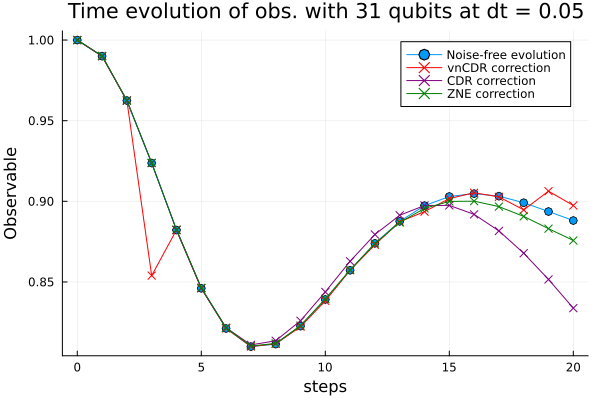

In [31]:
plot(0:steps, exact_expval_target; xlabel="steps", label="Noise-free evolution", marker=:o, legend=:topright)
# plot!(0:steps, noisy_expval_target; label="Noisy evolution", marker=:o, legend=:bottomleft)
plot!(0:steps, corrected_vnCDR; label="vnCDR correction", marker=:x, color="red")
plot!(0:steps, corrected_CDR; label="CDR correction", marker=:x, color="purple")
plot!(0:steps, corrected_ZNE, label="ZNE correction", marker=:x, color ="green")

plot!(ylabel="Observable", title ="Time evolution of obs. with $(nq) qubits at dt = $(round((T/steps), digits = 2))")

vnCDR combines the advantages of CDR and ZNE: it is very good in the first steps but still perform well when the noise does not follow the same trend as the noiseless evolution. However, vnCDR is not as reliable as ZNE. It seldomly produces unexplained behaviour for individual time steps.

Let us compare these different methods by looking it at the absolute error. We can not start from the first time steps, because we have an absolute error of 0 for some methods which can not be plotted in log-scale.

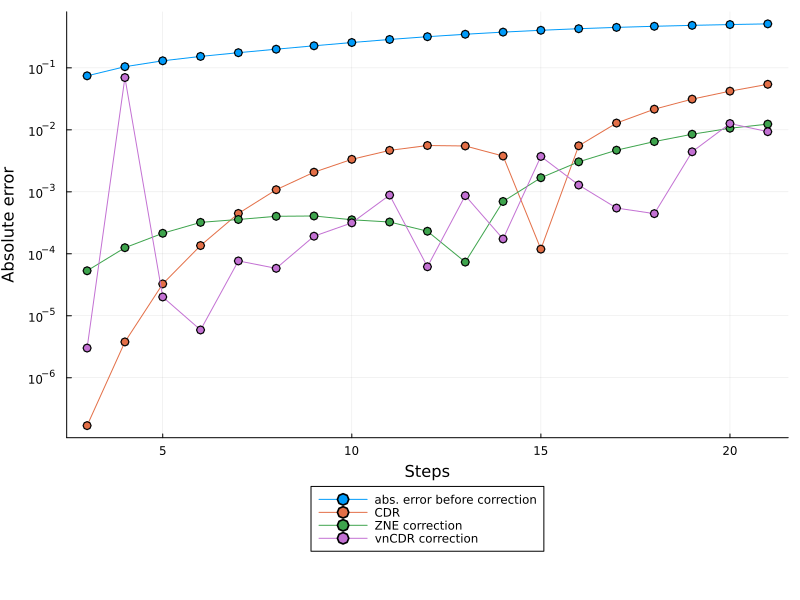

In [32]:
start = 3

# we plot the absolute error before cdr here but obviously the 
# absolute error at the beginning is the same for every method
plot(start:steps+1, abs_error_before_CDR[start:end], xlabel="Steps", ylabel = "Absolute error", label="abs. error before correction", marker=:o, legend=:outerbottom, yscale=:log10)

plot!(start:steps+1, abs_error_after_CDR[start:end], label="CDR", marker=:o)
plot!(start:steps+1, abs_error_after_ZNE[start:end], label="ZNE correction", marker=:o)
plot!(start:steps+1, abs_error_after_vnCDR[start:end], label="vnCDR correction", marker=:o, yscale=:log10)

plot!(yticks=10.0 .^ (-1:-1:-6), size=(800, 600))

We can see here that even though ZNE performs more consistently than vnCDR, even though the absolute error is often slightly larger for ZNE. However, the important thing to note is that the computational effort for vnCDR is much lower than for ZNE when using PP, due to the small angle regime leverage in vnCDR. This is not necessarily visible for small systems but will become important for bigger systems and/or lower truncations.

CDR is very good as long as the noisy values follows the same trend as the noiseless ones. This method will become increasingly interesting as the quantum computers will achieve low noise.

In conclusion, vnCDR presents a good efficiency-accuracy tradeoff while ZNE seems more regular. CDR should be kept for expectation values with a low noise.

# Correcting the utility experiment
We now apply our techniques to the utility experiment from IBM. We now use 127 qubits and the heavy hex topology from the eagle QPU. The system simulated is slightly different, as $\theta_J$ is fixed at $\pi/2$: this is the kicked transverse Ising field model. This simplifies greatly the simulation as the ZZ Pauli rotation gates become Cliffords with $\theta_J=\pi/2$. $\theta_h$ varies.

To avoid blowing up old computers by accident (like the one of my teammate), we do not generate the data directly in this notebook. However, it can be done from a laptop in a few minutes, depending on the chosen truncation coefficients. Keep in mind that you should not choose too low truncation coefficients, otherwise the calculations become untractable! Here we used `min_abs_coeff=1e-5` and `max_weight=8`.


In [33]:
# Mitigated values
IBM_mitigated_vals = [1.01688859, 1.00387483, 0.95615886, 0.95966435, 0.83946763,
    0.81185907, 0.54640995, 0.45518584, 0.19469377, 0.01301832,0.01016334] 
IBM_angles = [0.    , 0.1   , 0.2   , 0.3   , 0.4   , 0.5   , 0.6   , 0.7   , 0.8   , 1.    , 1.5707]

# Unmitigated values
IBM_unmitigated_vals = [ 0.4188991191900761,
0.004107759335343423,
0.11944580478416555,
0.49038646460776864,
0.4552471452020139,
0.055064655494323766,
0.3061535376123831,
0.4889782663914668,
0.3622122171682965,
-0.001980699802309258,
0.20175539633925924]
mixed_angles = [0.3, 1.0, 0.7, 0.0, 0.2, 0.8, 0.5, 0.1, 0.4, 1.5707, 0.6] 

# Flatiron tensor network values used as the most precised values known 
tn_vals = [9.99999254e-01,  9.99593653e-01,  9.95720077e-01,  9.88301532e-01,
        9.78553511e-01,  9.58023054e-01,  9.21986059e-01,  8.81726079e-01,
        8.49816779e-01,  8.24900527e-01,  7.91257641e-01,  7.37435202e-01,
        6.68573798e-01,  5.88096040e-01,  4.81874079e-01,  3.50316579e-01,
        2.26709331e-01,  1.39724659e-01,  7.86639143e-02,  4.24124371e-02,
        1.90595136e-02,  6.18879050e-03, -8.27168956e-04, -4.63372099e-03,
       -7.05202121e-03, -7.68387421e-03, -6.33121142e-03, -4.32594440e-03,
        6.52050191e-04,  1.72598340e-04,  5.64696020e-05, -7.70582375e-07]
tn_angles = LinRange(0, π/2, length(tn_vals));

As previously mentioned, we can not use our "loose" approach for vnCDR: $\theta_h$ is already smaller than the angle definition $\pi/20$ and $\theta_J$ is fixed. We do not want to reduce further our angle definition so that $\theta_h$ would be greater than it, because our training circuits would be too similar to each other. Thus, we use a "strict" approach (strict in the sense that it is closer to the original CPA approach): we change $\theta_h$ even though it is smaller than the angle definition. 

The difference with the procedure presented in the CPA paper is that we choose the angles of the training circuits at random, instead of taking the ones predefined in $\mathcal{T}$. This allows to reach similar results with much less training circuits (here we use only 10 instead of the 144 used in the paper).

In [34]:
utility_CDR = [0.9883711607425207, 0.9643848318902516, 0.9825779507627551,
            0.9909619282965854, 0.9913093066137038, 0.9659448740365627, 0.9842430619952781,
            0.990727412753033, 0.9846261259244113, 0.9635989137559526, 0.974050150057133]
        
utility_ZNE = [0.9916351872778839, 0.007826192971681004, 0.45834786130475613,
            1.0019965173649046, 0.9555606532828468, 0.22680534111257702, 0.7525166011828455,
            0.9534883139467709, 0.932118382415514, 0.0, 0.6098940092670162]

utility_vnCDR = [0.9903302179524793, 0.006843745922986413, 0.44721900165027506,
            0.9999817432654936, 0.9823731817809254, 0.2137406750447294, 0.7415378297913775,
            0.9963057555523244, 0.9538402692415033, 0.0, 0.5982390053824247]

mixed_angles = [0.3, 1.0, 0.7, 0.0, 0.2, 0.8, 0.5, 0.1, 0.4, 1.5707, 0.6];

The grey line is considered here as the closest to the ground truth and correspond to the values obtained via tensor network simulations from Flatiron Institute.

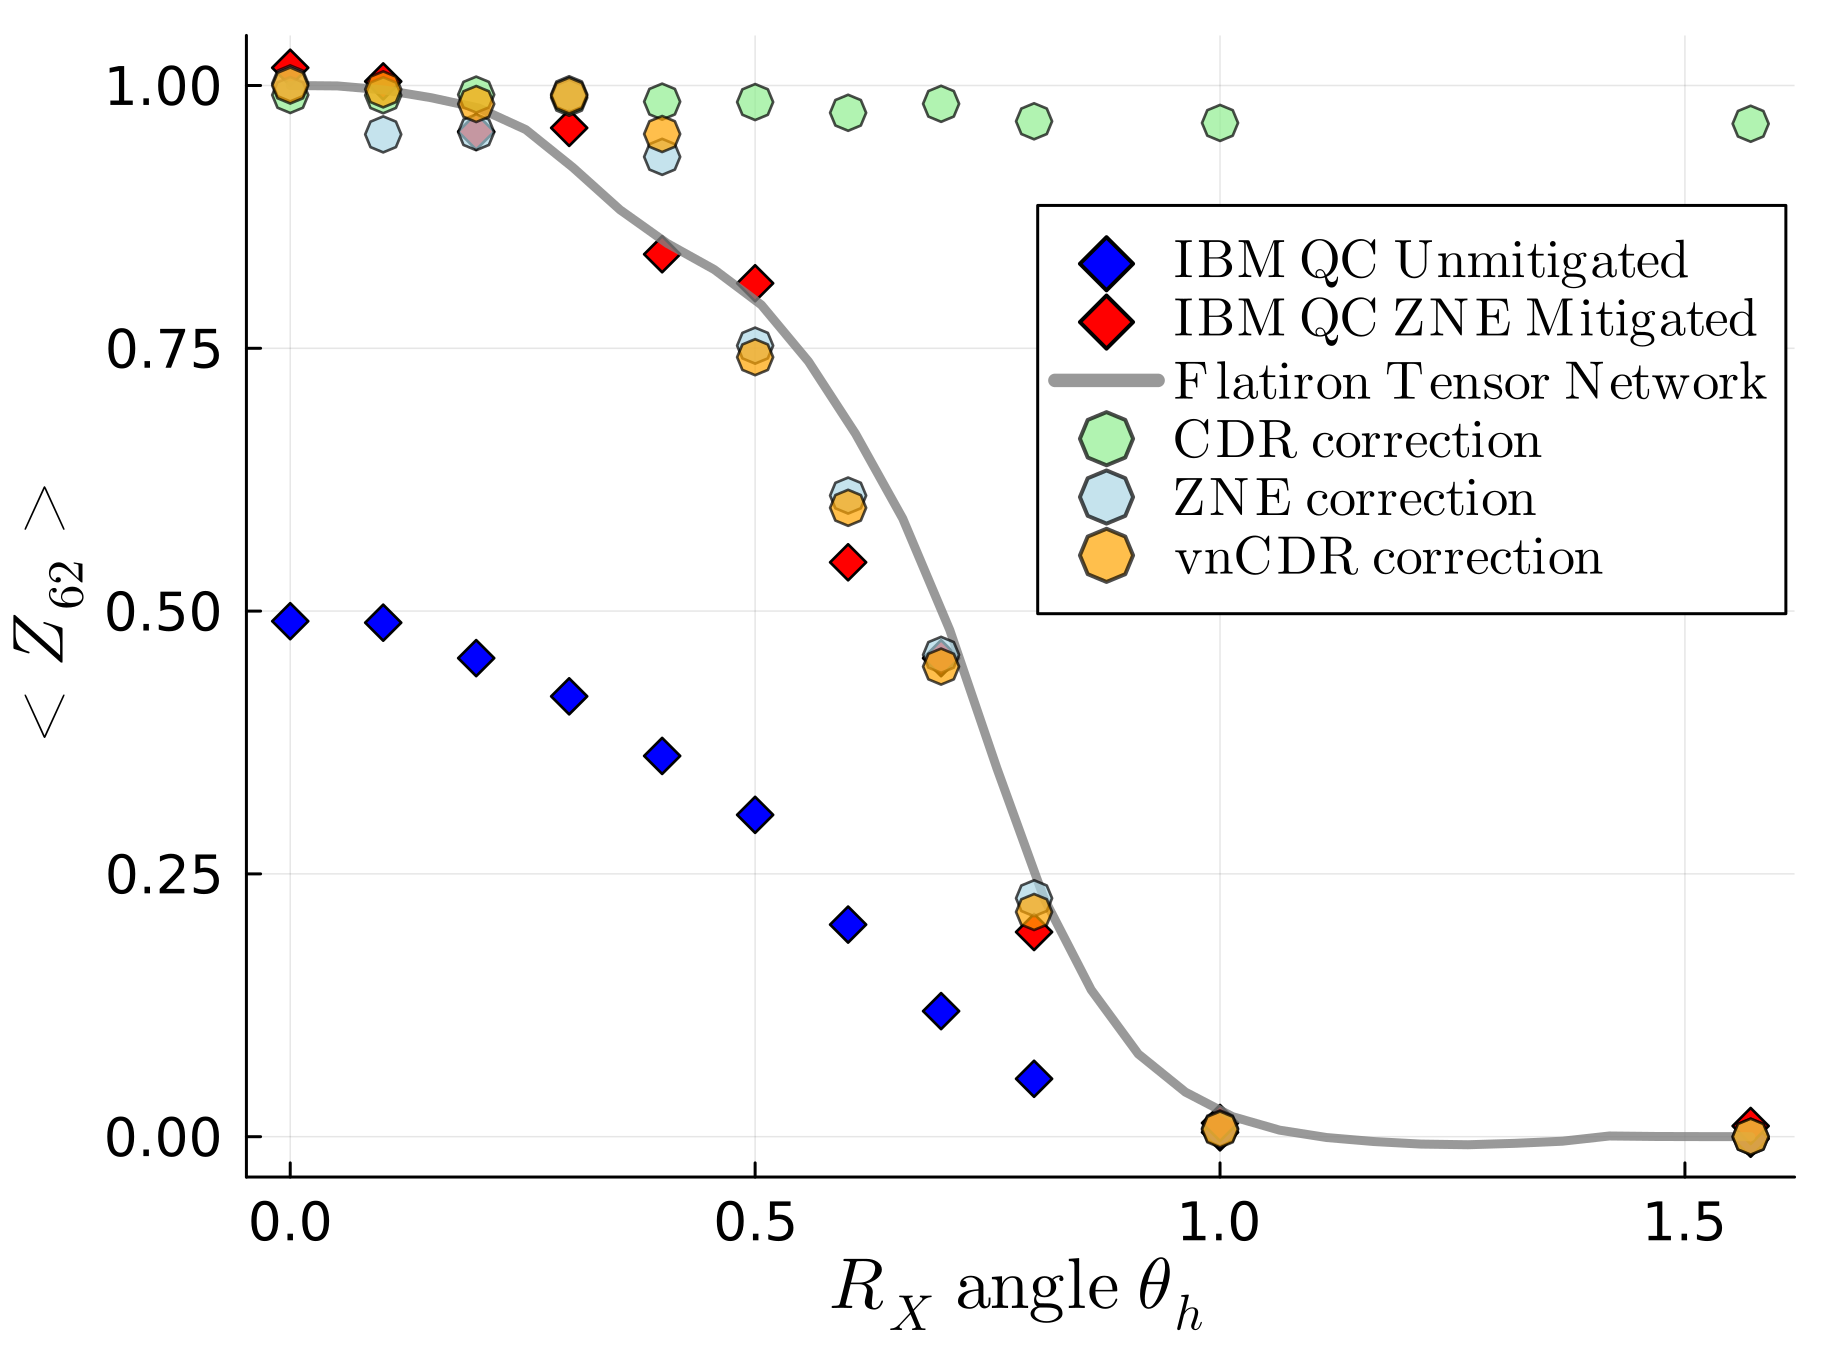

In [35]:
# data for comparison
scatter(mixed_angles, IBM_unmitigated_vals, label=L"\textrm{IBM\ QC\ Unmitigated}", marker=:diamond, 
            color=:blue, lw=2, 
            guidefontsize=16,
            tickfontsize=12,
            legendfontsize=12, ms=6)
scatter!(IBM_angles, IBM_mitigated_vals, label=L"\textrm{IBM\ QC\ ZNE\ Mitigated}", color="Red", ms=6, marker=:diamond)
plot!(tn_angles, tn_vals, label=L"\textrm{Flatiron\ Tensor\ Network}", color="grey", alpha=0.8, linewidth=3, ms=6)


# CPA / CDR
scatter!(mixed_angles, utility_CDR, label=L"\textrm{CDR\ correction}", color="lightgreen", linewidth=3,ms=6, marker=:o, alpha=0.7)
# ZNE
scatter!(mixed_angles, utility_ZNE, label=L"\textrm{ZNE\ correction}", color="lightblue",ms=6, marker=:o, alpha=0.7)
# vnCDR
scatter!(mixed_angles, utility_vnCDR, label=L"\textrm{vnCDR\ correction}", color="orange",ms=6, marker=:o, alpha=0.7)
# CDR
plot!(legend_position=(0.6, 0.8), xlabel=L" R_X\  \textrm{angle}\ \theta_h",
        ylabel=L"<Z_{62}>", size=(610,450), dpi=300)

Unsurprisingly, CDR fails dramatically beyong small angles regime. This is explained by the fact that near-Clifford circuits are not closed enough from the target circuit angle anymore. Thus, the pattern learned is not meaningful for our target circuit. However for quantum dynamics, the small angle regime is more pertinent as we want a good time resolution. Thus, CDR (more precisely CPA) still has potential for this application.

vnCDR and ZNE present similar results, with a small advantage for vnCDR. Both methods gives similar results as IBM mitigated values. This is a satisfying result given the fact that our noise model is very simple here, and not adapted to IBM hardware at all. Tuning the noise model is probably the main opportunity of improvement of the correction.